In [2]:
# a)

import numpy as np
import time

def naive_softmax_attention(Q, K, V):
    n, d_k = Q.shape
    d_v = V.shape[1]

    output = np.zeros((n, d_v))
    attention_weights = np.zeros((n, n))

    for q in range(n): # q - zapytanie
        # obliczamy iloczyny skalarne
        scores = np.zeros(n)
        for k in range(n): # k - klucz
            dot_product = 0.0
            for d in range(d_k):
                dot_product += Q[q, d] * K[k, d] # mnożenie wiersza Q z kolumnami K^T
            scores[k] = dot_product # wynikiem jest jeden wiersz macierzy QK^T
        scores = scores / np.sqrt(d_k)

        max_score = np.max(scores)
        exp_scores = np.exp(scores - max_score)
        softmax_scores = exp_scores / np.sum(exp_scores)
        attention_weights[q, :] = softmax_scores

        for j in range(d_v):  # dla każdego wymiaru wartości
            weighted_sum = 0.0
            for k in range(n):  # suma ważona wartości
                weighted_sum += softmax_scores[k] * V[k, j]
            output[q, j] = weighted_sum
    
    return output, attention_weights

def matrix_softmax_attention(Q, K, V):
    d_k = Q.shape[1]
    scores = np.matmul(Q, K.T)
    scores = scores / np.sqrt(d_k)

    max_scores = np.max(scores, axis=-1, keepdims=True) # ostatni wymiar
    exp_scores = np.exp(scores - max_scores)
    attention_weights = exp_scores / np.sum(exp_scores, axis=-1, keepdims=True)
    
    output = np.matmul(attention_weights, V)  
    
    return output, attention_weights

def benchmark_attention(n, d_k, d_v, random_state=42):
    np.random.seed(random_state)
    Q = np.random.randn(n, d_k)
    K = np.random.randn(n, d_k)
    V = np.random.randn(n, d_v)

    start_time = time.perf_counter()
    output_loop, weights_loop = naive_softmax_attention(Q, K, V)
    end_time = time.perf_counter()
    loop_time = end_time - start_time

    start_time = time.perf_counter()
    output_matrix, weights_matrix = matrix_softmax_attention(Q, K, V)
    end_time = time.perf_counter()
    matrix_time = end_time - start_time

    valid_output = np.allclose(output_loop, output_matrix)
    valid_weights = np.allclose(weights_loop, weights_matrix)

    print(f"Benchmark dla liczby sekwencji={n}, ilość kluczy={d_k}, ilość wartości={d_v}")
    print(f"Zgodność naiwna vs macierzowa: {valid_output and valid_weights}")
    print(f"Czas pętlowy: {loop_time:.4f}")
    print(f"Czas macierzowy: {matrix_time:.4f}")

benchmark_attention(64,  64, 64)
benchmark_attention(256, 64, 64)
benchmark_attention(512, 64, 64)

Benchmark dla liczby sekwencji=64, ilość kluczy=64, ilość wartości=64
Zgodność naiwna vs macierzowa: True
Czas pętlowy: 0.3054
Czas macierzowy: 0.0002
Benchmark dla liczby sekwencji=256, ilość kluczy=64, ilość wartości=64
Zgodność naiwna vs macierzowa: True
Czas pętlowy: 3.8171
Czas macierzowy: 0.0020
Benchmark dla liczby sekwencji=512, ilość kluczy=64, ilość wartości=64
Zgodność naiwna vs macierzowa: True
Czas pętlowy: 12.6424
Czas macierzowy: 0.0083


In [4]:
import numpy as np
import time
from sklearn.metrics import confusion_matrix

def conf_matrix(y_true, y_pred, n_classes):
    n_samples = len(y_true)
    # macierze one-hot 
    true_one_hot = np.eye(n_classes)[y_true] # (n_samples, n_classes)
    pred_one_hot = np.eye(n_classes)[y_pred] # (n_samples, n_classes)
    # macierz pomyłek
    # cm[i, j] = sum_k (true_one_hot[k, i] * pred_one_hot[k, j])
    cm = np.matmul(true_one_hot.T, pred_one_hot)
    
    return cm.astype(np.int64)

def generate_classification_data(n_samples, n_classes, error_rate=0.2):
    y_true = np.random.randint(0, n_classes, n_samples)
    y_pred = y_true.copy()

    n_errors = int(len(y_true) * error_rate)
    error_indices = np.random.choice(n_samples, n_errors, replace=False)

    for idx in error_indices:
        wrong_labels = [i for i in range(n_classes) if i != y_true[idx]]
        y_pred[idx] = np.random.choice(wrong_labels)
    
    return y_true, y_pred

def benchmark_confusion_matrix(n_samples, n_classes):
    print("================================================")
    print(f"Benchmark dla ilości danych={n_samples} oraz ilości klas={n_classes}:")
    y_true, y_pred = generate_classification_data(n_samples, n_classes)

    start_time = time.perf_counter()
    cm = conf_matrix(y_true, y_pred, n_classes)
    end_time = time.perf_counter()
    print(f"Czas macierzowego liczenia={(end_time-start_time):.4f} sekundy")

    start_time = time.perf_counter()
    cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
    end_time = time.perf_counter()
    print(f"Czas sklearn={(end_time-start_time):.4f} sekundy")

benchmark_confusion_matrix(10_000, 10)
benchmark_confusion_matrix(10_000, 50)
benchmark_confusion_matrix(10_000, 100)

benchmark_confusion_matrix(100_000, 10)
benchmark_confusion_matrix(100_000, 50)
benchmark_confusion_matrix(100_000, 100)



Benchmark dla ilości danych=10000 oraz ilości klas=10:
Czas macierzowego liczenia=0.0010 sekundy
Czas sklearn=0.0021 sekundy
Benchmark dla ilości danych=10000 oraz ilości klas=50:
Czas macierzowego liczenia=0.0109 sekundy
Czas sklearn=0.0017 sekundy
Benchmark dla ilości danych=10000 oraz ilości klas=100:
Czas macierzowego liczenia=0.0198 sekundy
Czas sklearn=0.0023 sekundy
Benchmark dla ilości danych=100000 oraz ilości klas=10:
Czas macierzowego liczenia=0.0114 sekundy
Czas sklearn=0.0094 sekundy
Benchmark dla ilości danych=100000 oraz ilości klas=50:
Czas macierzowego liczenia=0.0637 sekundy
Czas sklearn=0.0048 sekundy
Benchmark dla ilości danych=100000 oraz ilości klas=100:
Czas macierzowego liczenia=0.2096 sekundy
Czas sklearn=0.0041 sekundy


In [7]:
# c)
import numpy as np
import time

def batch_normalization_loop(x):
    n, d = x.shape
    out = np.zeros_like(x)

    for i in range(d):
        # średnia dla i-tej cechy (kolumny)
        mean = 0.0
        for j in range(n):
            mean+=x[j, i]
        mean /= n

        # wariancja dla i-tej cechy (kolumny)
        var = 0.0
        for j in range(n):
            diff = x[j, i] - mean
            var += diff * diff
        var /= n

        # Normalizacja
        std = np.sqrt(var)
        for j in range(n):
            out[j, i] = (x[j, i] - mean) / std
    
    return out

def batch_normalization_matrix(x):
    mean = np.mean(x, axis=0)
    var = np.var(x, axis=0)
    std = np.sqrt(var)
    normalized = (x - mean) / std
    return normalized

def benchmark_batch_normalization(batch_size, feature_size):
    print("=" * 50)
    print(f"Benchmark dla ilości batchy:{batch_size} oraz ilości feature:{feature_size}")
    x = np.random.randn(batch_size, feature_size)

    start_time = time.perf_counter()
    y_loop = batch_normalization_loop(x)
    end_time = time.perf_counter()
    print(f"Czas potrzebny na normalizacje pętlową: {(end_time - start_time):.4f}")

    start_time = time.perf_counter()
    y_loop = batch_normalization_matrix(x)
    end_time = time.perf_counter()
    print(f"Czas potrzebny na normalizacje macierzową: {(end_time - start_time):.4f}")

benchmark_batch_normalization(128, 1024)
benchmark_batch_normalization(128, 4096)
benchmark_batch_normalization(256, 4096)







Benchmark dla ilości batchy:128 oraz ilości feature:1024
Czas potrzebny na normalizacje pętlową: 0.2590
Czas potrzebny na normalizacje macierzową: 0.0107
Benchmark dla ilości batchy:128 oraz ilości feature:4096
Czas potrzebny na normalizacje pętlową: 0.8722
Czas potrzebny na normalizacje macierzową: 0.0074
Benchmark dla ilości batchy:256 oraz ilości feature:4096
Czas potrzebny na normalizacje pętlową: 1.2487
Czas potrzebny na normalizacje macierzową: 0.0129


Benchmark dla ilości danych n=4000
Implementacja pętlami w czasie: 25.8297
Implementacja macierzowa w czasie: 0.0079


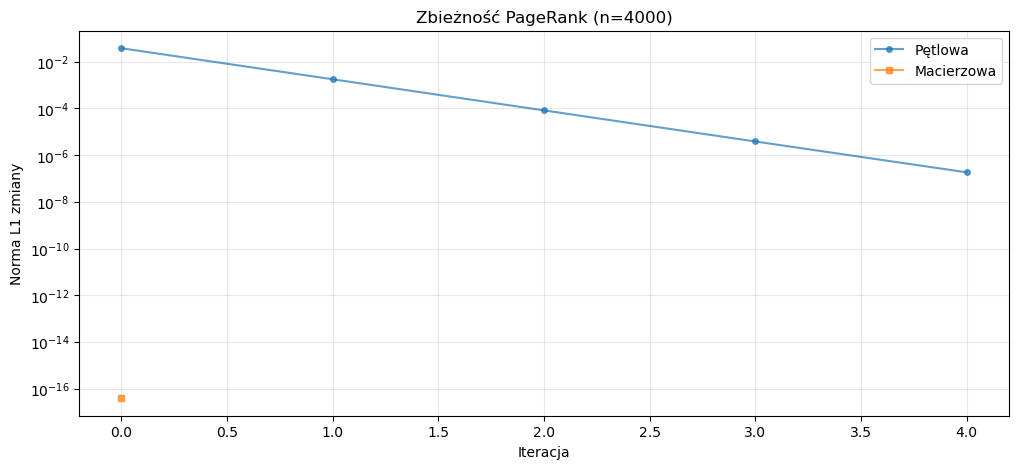

In [3]:
# d)
import numpy as np 
import time 
import matplotlib.pyplot as plt 

def pagerank_loop(M, d=0.85, max_iter=100, eps=1e-6):
    n = M.shape[0]
    r = np.ones(n) / n
    history = [r.copy()]

    for _ in range(max_iter):
        r_new = np.zeros(n)
        for i in range(n):
            for j in range(n):
                # M[j, i] to ppb przejścia z j do i
                if M[j, i] != 0:
                    r_new[i] += M[j, i] * r[j]
        
        r_new = d * r_new + (1 - d) / n
        history.append(r_new.copy())
        if np.linalg.norm(r_new - r, 1) < eps:
            break
        r = r_new
    return r, history

def pagerank_matrix(M, d=0.85, max_iter=100, eps=1e-6):
    n = M.shape[0]
    r = np.ones(n) / n
    history = [r.copy()]
    teleport = (1 - d) / n

    for _ in range(max_iter):
        r_new = d * M.dot(r) + teleport
        history.append(r_new.copy())
        if np.linalg.norm(r_new - r, 1) < eps:
            break
        r = r_new

    return r, history

def create_random_transition_matrix(n, sparsity=0.9):
    # Tworzenie rzadkiej macierzy
    M = np.random.rand(n, n)
    
    # Dodanie sparsity - zerowanie losowych elementów
    mask = np.random.rand(n, n) < sparsity
    M[mask] = 0
    
    # Upewnienie się, że każdy wiersz ma przynajmniej jedno wyjście
    for i in range(n):
        if np.sum(M[i, :]) == 0:
            M[i, np.random.randint(n)] = 1
    
    # Normalizacja wierszy do sumy = 1
    row_sums = M.sum(axis=1, keepdims=True)
    M = M / row_sums
    return M


def benchmark_pagerank(n, d=0.85, max_iter=100):
    print("=" * 50)
    print(f"Benchmark dla ilości danych n={n}")
    M = create_random_transition_matrix(n)
    
    start_time = time.perf_counter()
    r_loop, history_loop = pagerank_loop(M, d, max_iter)
    end_time = time.perf_counter()
    print(f"Implementacja pętlami w czasie: {(end_time - start_time):.4f}")

    start_time = time.perf_counter()
    r_matrix, history_matrix = pagerank_matrix(M, d, max_iter)
    end_time = time.perf_counter()
    print(f"Implementacja macierzowa w czasie: {(end_time - start_time):.4f}")

    plt.figure(figsize=(12, 5))
    # plt.subplot(1, 2, 1)
    loop_array = np.array(history_loop)
    matrix_array = np.array(history_matrix)
    loop_changes = [np.linalg.norm(loop_array[i+1] - loop_array[i], 1) 
                   for i in range(len(loop_array)-1)]
    matrix_changes = [np.linalg.norm(matrix_array[i+1] - matrix_array[i], 1) 
                     for i in range(len(matrix_array)-1)]
    
    plt.semilogy(loop_changes, 'o-', label='Pętlowa', markersize=4, alpha=0.7)
    plt.semilogy(matrix_changes, 's-', label='Macierzowa', markersize=4, alpha=0.7)
    plt.xlabel('Iteracja')
    plt.ylabel('Norma L1 zmiany')
    plt.title(f'Zbieżność PageRank (n={n})')
    plt.grid(True, alpha=0.3)
    plt.legend()

benchmark_pagerank(4_000)